In [2]:
#7章　一般化線形混合モデル(GLMM)

#この教科書の実装はR言語によるものとなっている。
#それをPythonにて実装しなおす

#########この章の簡単な説明######
"""""
3,5,6章では、種子数を体のサイズや施肥処理を入れて分析をした。
この章では個体差や場所差といった要素を考慮に入れたモデルを作成する。
※注
glmmはPythonで実装することが難しそうなので、pyperを使ってPythonからRを叩いてglmmを使用する。
"""""

import pandas as pd
d=pd.read_csv("http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/glmm/data.csv")
d.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


In [3]:
#各変数の型の確認
d.dtypes

N     int64
y     int64
x     int64
id    int64
dtype: object

In [4]:
#変数の概要を調べる
d.describe()

,N,y,x,id
count,100.0,100.000000,100.000000,100.000000
mean,8.0,3.810000,4.000000,50.500000
std,0.0,3.070534,1.421338,29.011492
min,8.0,0.000000,2.000000,1.000000
25%,8.0,1.000000,3.000000,25.750000
50%,8.0,3.000000,4.000000,50.500000
75%,8.0,7.000000,5.000000,75.250000
max,8.0,8.000000,6.000000,100.000000


In [5]:
#第6章の結果を比較のために再実装
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf 

log_model = smf.glm(formula="y + I(N - y) ~ x ",data=d, family=sm.families.Binomial())
log_res = log_model.fit()
print('Parameters: ', log_res.params)
print(log_res.summary())
print(log_res.summary2())

Parameters:  Intercept   -2.148745
x            0.510381
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Tue, 09 Oct 2018   Deviance:                       513.84
Time:                        17:47:42   Pearson chi2:                     428.
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000     

(array([2., 0., 0., 5., 0., 6., 4., 0., 2., 1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <a list of 1 Patch objects>)

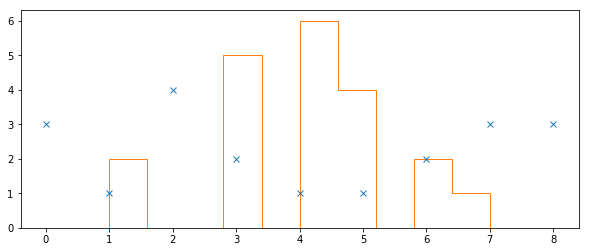

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import *
#二項分布に従っていなそう・・・ということを確認
#過分散があるっぽい
#例としてx=4のデータを抽出
x4 = d[d["x"]==4]
fig1 = plt.figure(figsize=(10,4))
ax1 = fig1.add_subplot(111)
ax1.plot(x4["y"].value_counts().index,x4["y"].value_counts(),'x')
p=1/(1+np.exp(2.1487-0.5104*4))
plt.hist(binomial(8, p=p,size=20),histtype="step")

In [16]:
print("x=4のデータにおけるyの平均：" , np.mean(x4["y"]))
#不偏分散を求めるためにはddof=1を設定する
print("x=4のデータにおけるyの分散：", np.var(x4["y"],ddof=1))
#もしx=4におけるyが二項分布に従うなら、生存確率の平均は約0.5、分散は8*0.5*0.5=約2.0
#分散が理論値と比べると大きい→過分散(平均に関しても20*0.5=10なので、理論値のとのズレはある)

x=4のデータにおけるyの平均： 4.05
x=4のデータにおけるyの分散： 8.365789473684211


In [104]:
#上記の結果より、各個体を同じ二項分布に従っていると仮定するのは厳しい
#観測されていない差があるのでは？①個体差②場所差　など・・・
#→GLMM(一般化線形混合モデル)の導入

In [17]:
#GLMMの実装　pythonにはmixedlmモジュールはあるが、GLMに対応していない(OLSにしか使えないみたい)
#個体差があるとしてモデルを作成する
#pyperを使ってRに受け渡して実行

import pyper as pr

r = pr.R(use_numpy='True', use_pandas='True')
#pythonのデータフレームdをR側でdという名前のデータフレームに割り当てる。
r.assign("d",d);
#RでGLMMを実行する
r('library(glmmML)')
print(r('summary(glmmML(cbind(y,N-y)~x,data=d,family=binomial,cluster=id))'))

try({summary(glmmML(cbind(y,N-y)~x,data=d,family=binomial,cluster=id))})

Call:  glmmML(formula = cbind(y, N - y) ~ x, family = binomial, data = d,      cluster = id) 


              coef se(coef)      z Pr(>|z|)
(Intercept) -4.190   0.8777 -4.774 1.81e-06
x            1.005   0.2075  4.843 1.28e-06

Scale parameter in mixing distribution:  2.408 gaussian 
Std. Error:                              0.2202 

        LR p-value for H_0: sigma = 0:  2.136e-55 

Residual deviance: 269.4 on 97 degrees of freedom 	AIC: 275.4 



In [ ]:
#上記の推計結果は教科書と微妙に違う
#これはglmmMLの計算方法によるものらしい。methodに何も指定しない場合、Laplace 近似法 が使われるが、教科書ではGauss-Helmite 法
#を使っているらしい。(筆者webサイトより)

In [125]:
#Gauss-Helmite 法による推計
r = pr.R(use_numpy='True', use_pandas='True')
r.assign("d",d);
r('library(glmmML)')
print(r('summary(glmmML(cbind(y,N-y)~x,data=d,family=binomial,cluster=id,method = "ghq"))'))

try({summary(glmmML(cbind(y,N-y)~x,data=d,family=binomial,cluster=id,method = "ghq"))})

Call:  glmmML(formula = cbind(y, N - y) ~ x, family = binomial, data = d,      cluster = id, method = "ghq") 


               coef se(coef)      z Pr(>|z|)
(Intercept) -4.1296   0.9055 -4.561 5.10e-06
x            0.9903   0.2141  4.625 3.75e-06

Scale parameter in mixing distribution:  2.494 gaussian 
Std. Error:                              0.3093 

        LR p-value for H_0: sigma = 0:  1.792e-56 

Residual deviance: 264.5 on 97 degrees of freedom 	AIC: 270.5 

